## 🧠 Objetivo

Creamos una red que:

Recibe como input una posición de ajedrez ya procesada como tensor de características (por ejemplo, un tensor 8x8xN con canales de piezas, movilidad, etc.).

Usa una Embedding para representar la fase del juego: opening=0, middlegame=1, endgame=2.

Usa ConditionalBatchNorm para que la normalización se adapte a la fase.

Predice si la posición tiene táctica (tactical_opportunity = 1) o no (0).



## 🎯 Keras

Keras es una librería de alto nivel para construir redes neuronales. Sirve para crear, entrenar, evaluar y desplegar modelos de deep learning de manera sencilla, legible y eficiente.

Hoy en día, Keras está integrada dentro de TensorFlow (como tf.keras), y se ha convertido en su interfaz principal para el desarrollo de modelos.

🎯 ¿Para qué sirve Keras?
Función	Descripción breve
🔧 Definir modelos	Puedes crear redes neuronales secuenciales o más complejas con facilidad
🧠 Entrenar modelos	Entrena modelos con .fit() usando datasets, validaciones, callbacks, etc.
📊 Evaluar rendimiento	Usa .evaluate() para calcular precisión, pérdida, etc.
🔍 Realizar predicciones	Aplica el modelo entrenado a nuevos datos con .predict()
📦 Guardar/cargar modelos	Guarda modelos entrenados con .save() y recargalos con .load_model()

🏗️ Ejemplo simple con Keras
python
Copiar
Editar
import tensorflow as tf
from tensorflow.keras import layers, models

# 🧱 Crear el modelo
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10,)),
    layers.Dense(1, activation='sigmoid')
])

# ⚙️ Compilarlo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🏃‍♂️ Entrenarlo con datos ficticios
import numpy as np
X = np.random.rand(100, 10)
y = np.random.randint(0, 2, size=(100,))

model.fit(X, y, epochs=5)
✅ Ventajas de Keras
Simplicidad: código limpio y expresivo

Flexibilidad: permite modelos personalizados (subclasificando Model)

Velocidad de prototipado: ideal para experimentar

Compatible con producción: a través de TensorFlow y exportación a TFLite o TF Serving

📚 ¿Qué podés construir con Keras?
Clasificadores de imágenes (CNN)

Modelos de texto (LSTM, Transformer)

Redes GAN

Autoencoders

Modelos multientrada y multisalida

Modelos para juegos, recomendaciones, ciencia de datos, etc.



## 🧠Predicción de errores táticos usando red neuronal y Keras

Entrena un modelo de red neuronal para predecir errores tácticos en ajedrez usando Keras, combinando features posicionales con embeddings por fase del juego y nivel ELO. Se emplea ConditionalBatchNorm para adaptar dinámicamente la normalización según la fase (opening, middlegame, endgame).

In [ ]:
from tensorflow.keras import layers
print("✅ tensorflow.keras funciona correctamente")


2025-06-16 07:14:31.557531: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 07:14:31.837306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-16 07:14:31.837414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-16 07:14:31.890370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-16 07:14:32.042820: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 07:14:32.045176: I tensorflow/core/platform/cpu_feature_guard.cc:1

✅ tensorflow.keras funciona correctamente


In [5]:
# %pip install tensorflow

# Cargando librerias necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
#testeo de entrorno python

import sys
print(sys.executable)


/usr/local/bin/python


## 🧠  ConditionalBatchNorm 

🧠 ¿Qué es ConditionalBatchNorm?
Es una versión inteligente y adaptable de la capa BatchNormalization.

Mientras que BatchNormalization normaliza igual para todos los datos, ConditionalBatchNorm cambia su comportamiento según una condición externa, como:

la fase del juego (phase)

el tipo de jugador (blitz, bullet, clásica)

el estilo del modelo (Stockfish vs humano)

📊 Analogía: entrenador personalizado
Imaginá un gimnasio con varios entrenadores.
Todos hacen calentar a sus alumnos con una rutina general.
Pero después, cada entrenador personaliza los ejercicios según el tipo de alumno: principiante, intermedio, avanzado.

📌 Eso hace ConditionalBatchNorm:
normaliza el input como siempre, pero después ajusta con un γ y β específicos para cada “condición” (fase, estilo, nivel).



## ⚙️ ¿Qué pasa matemáticamente?

BatchNormalization común:

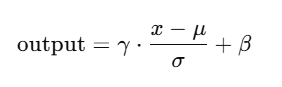

→ γ y β son fijos (se entrenan como pesos).

ConditionalBatchNorm:

 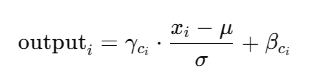
 
→ γ y β dependen de la condición c_i (por ejemplo, phase="endgame"), y se obtienen usando un Embedding.

In [ ]:
class ConditionalBatchNorm(layers.Layer):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.bn = layers.BatchNormalization(center=False, scale=False)
        self.gamma = layers.Embedding(num_conditions, num_features)
        self.beta = layers.Embedding(num_conditions, num_features)

    def call(self, x, condition):
        norm = self.bn(x)
        gamma = self.gamma(condition)
        beta = self.beta(condition)
        return gamma * norm + beta


## 🔍 ¿Por qué usarlo?

## 🧠 Modelo personalizado

### ¿Porque no todas las fases del juego tienen las mismas estadísticas?:

|Fase	|Características comunes|
|Apertura	|Poco material movido, pocas amenazas|
|Medio juego	|Alta complejidad táctica, muchas piezas activas|
|Final	|Pocas piezas, movilidad reducida, amenazas sutiles|

Entonces, aplicar la misma normalización a todas las fases puede mezclar peras con manzanas.

ConditionalBatchNorm adapta los ajustes de escala y desplazamiento para cada contexto.



In [ ]:
class TacticPhaseModel(tf.keras.Model):
    def __init__(self, input_dim, num_phases, num_elo_bins, elo_embed_dim=4):
        super().__init__()
        self.elo_embedding = layers.Embedding(input_dim=num_elo_bins, output_dim=elo_embed_dim)
        self.dense1 = layers.Dense(64)
        self.bn = ConditionalBatchNorm(64, num_phases)
        self.relu = layers.ReLU()
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x, phase_id, elo_id = inputs
        elo_vec = self.elo_embedding(elo_id)
        elo_vec = tf.reshape(elo_vec, [tf.shape(x)[0], -1])
        x = tf.concat([x, elo_vec], axis=1)
        x = self.dense1(x)
        x = self.bn(x, phase_id)
        x = self.relu(x)
        x = self.dense2(x)
        return self.output_layer(x)


## 🧠 Carga del dataset 

In [ ]:
df = pd.read_parquet("training_dataset.parquet")
df = df.dropna(subset=["error_label", "phase", "player_color", "standardized_elo"])
df.head()

## 🧠 Preprocesamiento 
Limpieza y codificación de variables categóricas.

In [ ]:
le_phase = LabelEncoder()
df["phase_id"] = le_phase.fit_transform(df["phase"])

le_color = LabelEncoder()
df["color_id"] = le_color.fit_transform(df["player_color"])


## 🧠 Discreticacion de ELO Standarizado
En una etapa anterior se standariza el elo Liches y el Chess.com para usar uno en común para todo el dataset.

Los elo_bins son rangos de ELO discretizados que se usan para transformar el standardized_elo (que es un número continuo) en un índice entero que pueda ser usado como entrada de un Embedding.

🎯 ¿Por qué discretizar ELO?
Los modelos no pueden usar directamente un número como 1725.4 en un Embedding, porque el Embedding espera un índice entero. Entonces agrupamos los valores de ELO en intervalos o bins, como:

```python
elo_bins = [0, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 3000]
```
Esto divide el rango de ELO en categorías:

Bin ID	Rango de ELO
| Bin ID | Rango de ELO      |
|--------|-------------------|
| 0      | [0, 1200)         |
| 1      | [1200, 1400)      |
| 2      | [1400, 1600)      |
| 3      | [1600, 1800)      |
| 4      | [1800, 2000)      |
| 5      | [2000, 2200)      |
| 6      | [2200, 2400)      |
| 7      | [2400, 3000]      |

Después se hace:

```python
df["elo_bin_id"] = pd.cut(df["standardized_elo"], bins=elo_bins, labels=False)
```
Eso transforma un standardized_elo = 1732 → elo_bin_id = 3

📌 ¿Para qué lo usamos?

El índice elo_bin_id se pasa a una capa Embedding, que convierte cada bin en un vector denso:

```python
Embedding(input_dim=8, output_dim=4)
```
→ Cada rango de ELO tiene su propia representación aprendible, lo que permite al modelo adaptarse al nivel del jugador.

In [ ]:
elo_bins = [0, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 3000]
df["elo_bin_id"] = pd.cut(df["standardized_elo"], bins=elo_bins, labels=False)
df = df.dropna(subset=["elo_bin_id"])
df["elo_bin_id"] = df["elo_bin_id"].astype(int)


✅ ¿Qué hace el código?
Carga archivo .parquet.

Usa pd.qcut(..., q=8) para dividir el ELO en 8 grupos con igual cantidad de muestras.

Muestra una tabla como esta:

| Bin ID | Count | Min  | Max  | Mean |
|--------|-------|------|------|------|
| 0      | 5000  | 600  | 1203 | 1020 |
| 1      | 5000  | 1204 | 1350 | 1285 |
| ...    | ...   | ...  | ...  | ...  |

Esto te da bins más representativos de la distribución real de tu dataset.

## 🧠 Selección de features

In [ ]:

features = ["branching_factor", "self_mobility", "opponent_mobility",
            "is_low_mobility", "material_total", "num_pieces",
            "has_castling_rights", "is_center_controlled", "is_pawn_endgame",
            "is_repetition", "threatens_mate", "is_forced_move",
            "is_tactical_sequence", "standardized_elo", "color_id"]

X = df[features]
y = df["error_label"]
phase_ids = df["phase_id"]
elo_ids = df["elo_bin_id"]


X_train, X_test, y_train, y_test, phase_train, phase_test, elo_train, elo_test = train_test_split(
    X_scaled, y, phase_ids, elo_ids, test_size=0.2, random_state=42
)


## 🧠 Escalado de datos

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 🧠 División train/test

In [ ]:
X_train, X_test, y_train, y_test, phase_train, phase_test = train_test_split(
    X_scaled, y, phase_ids, test_size=0.2, random_state=42
)


## 🧠 Definición del modelo con entrada condicional

In [ ]:
input_main = layers.Input(shape=(X_train.shape[1],), name="features_input")
input_phase = layers.Input(shape=(), dtype=tf.int32, name="phase_input")

x = layers.Dense(64)(input_main)
x = ConditionalBatchNorm(64, num_conditions=len(le_phase.classes_))(x, input_phase)
x = layers.ReLU()(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)  # cambiar a softmax si hay múltiples clases

model = Model(inputs=[input_main, input_phase], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## 🧠 Entrenar modelo

In [ ]:
model.fit(x={"features_input": X_train, "phase_input": phase_train},
          y=y_train, batch_size=32, epochs=10,
          validation_data=({"features_input": X_test, "phase_input": phase_test}, y_test))


## 🧠Evaluación

In [ ]:
y_pred = model.predict((X_test, phase_test, elo_test))
y_pred_bin = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_bin))
sns.heatmap(confusion_matrix(y_test, y_pred_bin), annot=True)
plt.title("Matriz de confusión")
plt.show()

✅ Aplicación para chess_trainer
Cuando se hace:

```python

x = ConditionalBatchNorm(64, num_conditions=3)(x, phase_id)
```
Estás diciendo:

"Normalizar x, pero ajuste la escala y el sesgo final en función de si estoy en apertura, medio juego o final."